This is an example of using an API to extract data, save that data into SQL, then use SQL to pull data and use it to graph stock prices over time. 

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import sqlite3

import quandl
from matplotlib.finance import candlestick_ohlc

In [13]:
quandl.ApiConfig.api_key = "Your Quandle Key Here"

In [14]:

data_apple_candle = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date', 'Ticker', 'ADJ_CLOSE','ADJ_HIGH', 'ADJ_LOW', 'ADJ_OPEN', 'ADJ_VOLUME'] },
                        ticker = 'aapl',
                        date = { 'gte': '1980-12-01', 'lte': '2016-12-31' }, paginate=True)
data_apple_candle['Date2'] = data_apple_candle['date'].apply(lambda d: mdates.date2num(d.to_pydatetime()))
data_apple_candle.reset_index(drop=True, inplace=True)
data_apple_candle['date'] = pd.to_datetime(data_apple_candle['date'], format='%Y-%m-%d')
#data_apple_candle = data_apple_candle.set_index('date')
#data_apple_candle.index.name = None

types = data_apple_candle.apply(lambda x: pd.lib.infer_dtype(x.values))
for col in types[types=='unicode'].index:
	data_apple_candle[col] = data_apple_candle[col].astype(str)

data_apple_candle.columns = [str(c) for c in data_apple_candle.columns]


In [17]:
connection = sqlite3.connect(':memory:')
connection = sqlite3.connect('Project.sl3')
cursor = connection.cursor()

SQL_table = """
      CREATE TABLE SP500 (
      entry VARCHAR PRIMARY KEY ,
      Ticker VARCHAR (5) NOT NULL,
      Security VARCHAR (100) NOT NULL,
      Sector VARCHAR (100) NOT NULL,
      Industry VARCHAR (1000) NOT NULL, 
      Headquarters VARCHAR (1000) NOT NULL,
      CIK INTERGER (100) NOT NULL,
      Date date NULL,
      Close INTEGER(100) NULL
    ) 
    """
SQL_table

cursor.execute("DROP TABLE IF EXISTS SP500")
cursor.execute(SQL_table)
connection.commit()


for (Ticker, Close, Date, Security) in cursor:
    print (Ticker, Security, Close, Date)


pd.DataFrame(data_apple_candle).to_sql('data_apple_candle', connection, flavor='sqlite',
                schema=None, if_exists='replace', index=True,
                index_label=None, chunksize=None, dtype=None)

C:\Users\APL\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\sql.py:531: FutureWarning: the 'flavor' parameter is deprecated and will be removed in a future version, as 'sqlite' is the only supported option when SQLAlchemy is not installed.
  _validate_flavor_parameter(flavor)


Text(0.5,1,'AAPL')

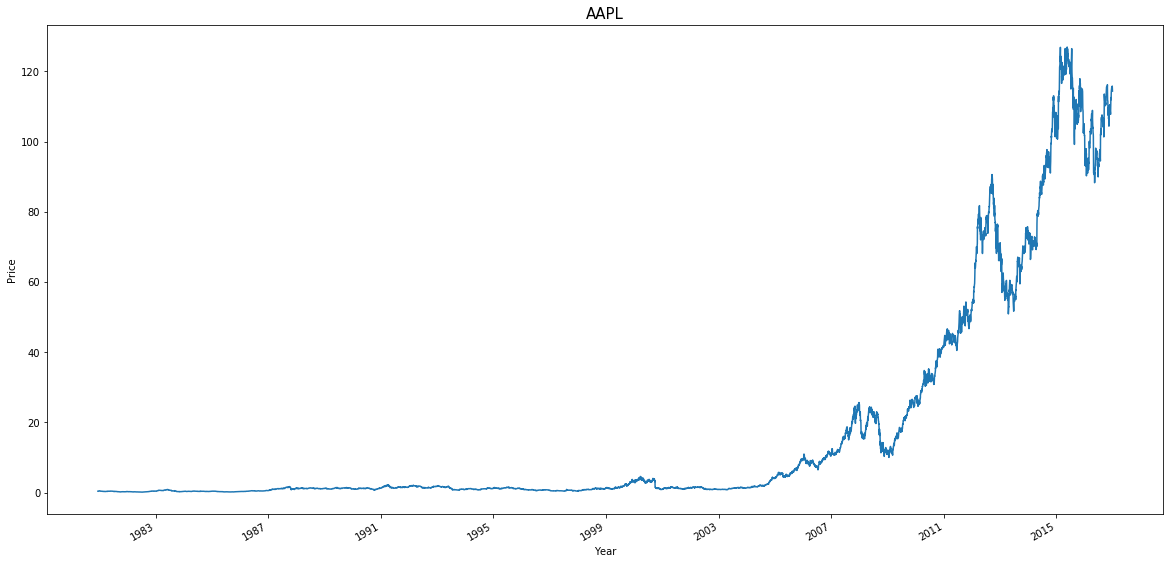

In [18]:
connection = sqlite3.connect(':memory:')
connection = sqlite3.connect('Project.sl3')
cursor = connection.cursor()

data_apple_all = pd.read_sql_query('SELECT Ticker, adj_close, Date FROM data_apple_candle', connection)

data_apple_all['date'] = pd.to_datetime(data_apple_all['date'], format='%Y-%m-%d')
#data_apple_all['date'] = data_apple_all['date'].dt.strftime('%Y-%b')
data_apple_all = data_apple_all.set_index('date')
data_apple_all.index.name = None

aapl_all = data_apple_all['adj_close'].plot(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("AAPL", fontsize=15)

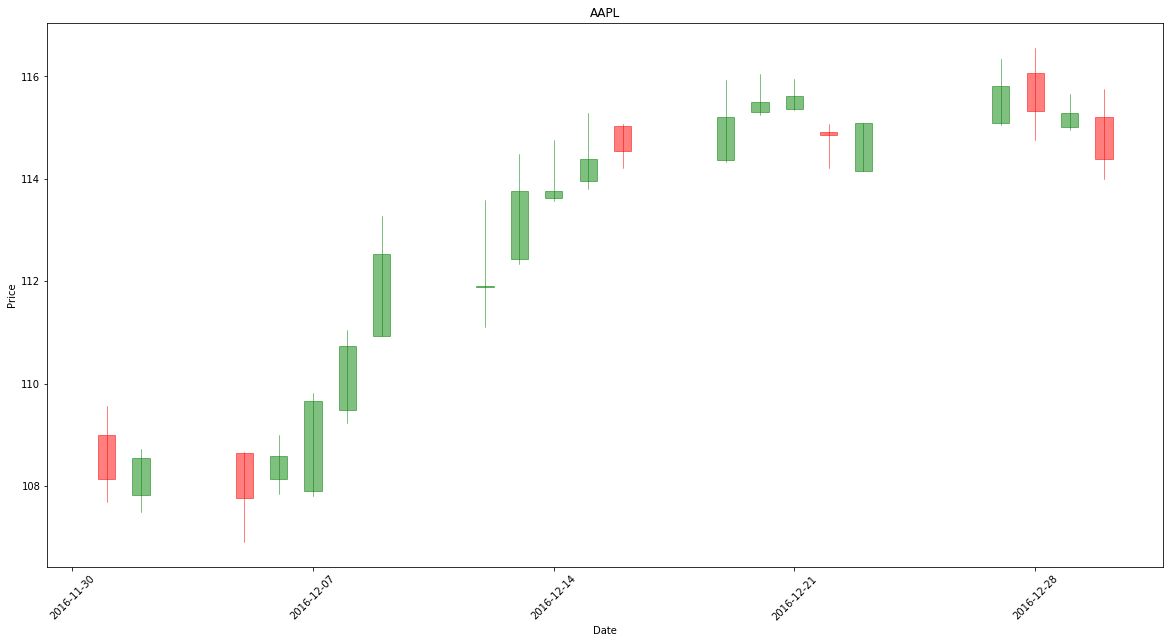

In [19]:
data_apple_candle_dec2016 = pd.read_sql_query('SELECT Ticker, adj_close, adj_high, adj_low, adj_open, adj_volume, Date2 FROM data_apple_candle where Date2 between 736299 and 736328', connection)


tuples = [tuple(x) for x in data_apple_candle_dec2016[['Date2','adj_open','adj_high','adj_low','adj_close']].values]
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL")
candlestick_ohlc(ax, tuples, width=.5, colorup='g', alpha =.5);